# Deep Learning Training Loop Implementation

In this notebook, a simple training loop implementation build on top of PyTorch is provided. The code demonstrates how to assemble a machine leanring data processing pipeline using `torch`, `torchvision` and a bunch of simple Python classes to classify images from MNIST and CIFAR10 datasets.

<br/>

![](./assets/loop.gif)

<br/>

> **Note:** All the code we need to implement the training loop is intentionally kept in the single notebook (including helper methods required to build models) to simplify reading. You would like to split the code into smaller pieces if running from python scripts to improve maintainability and modularity.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import math
from pathlib import Path
import re
import sys

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import MNIST, CIFAR10
from tqdm import tqdm_notebook as tqdm

In [4]:
default_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## First Glance

Let's pick a first glance onto the generic structure of the training process to understand what we need to implement.

### Pseudocode
Using the pseudocode, we can represent the training loop as follows:

```python
for epoch in epochs:
    for phase in (train, valid):
        for x, y in phase.data_loader:
            out = model.forward(x)
            loss = compute_loss(out, y)
            loss.backwards()
```

The structure looks quite simple, and is generic enough to train a wide range of Deep Learning models, including image classification, regression, text processing, objects detection, etc.

However, that would be nice to have a bit more than forward and backward passes. We probably would like to adjust learning rate during training, compute performance metrics, or at least to log computed loss values. We could directly update the structure represented above and add specific functions for each of these cases:
```python
for epoch in epochs:
    epoch_metrics = {}
    for phase in (train, valid):
        phase_metrics = defaultdict(list)
        for x, y in phase.data_loader:
            out = model.forward(x)
            loss = compute_loss(out, y)
            phase_metrics[phase.name].append(loss)
            loss.backwards()
        epoch_metrics[phase.name] = averaged_loss(phase_metrics[phase.name])
```
Though this approach works as expected, it makes the code cluttered, more sophisticated. It is easy to introduce a regression bug. But without these improvements, our basic training is not very useful because we can't track progress or tune the model parameters during execution. Fortunatelly, there is a way to make our loop more powerful yet keep its simplicity.

### Callbacks
The idea is to use _callbacks_, or _observers_. Instead of adding changes into training loop's code, we factor it out into separate objects. The observer is a well-known [design pattern](http://www.gameprogrammingpatterns.com/observer.html) in object-oriented languages. It allows to decouple a sophisticated system into more maintainable fragments. We don't try to encapsulate all possible functions into a single class or function, but _delegate_ calls to subordinate modules. Each module is responsible to properly react onto received notification. It can also ignore the notification in case if the message intended for someone else.

![](./assets/training_loop.png)

Take a look at the picture above. It shows a schematical organization of our improved training loop. Each colored section is a sequence of method calls delegated to the group of callbacks. Each callback has methods like `epoch_started`, `batch_started`, etc. but usually implements only some of them. For example, consider `loss` metric computation callback. It doesn't really care about methods that are executed before backwards propagation is completed. But as soon as `batch_ended` notification is received, it computes a batch loss.

This approach is heavy used by `Keras` and, especially, `fastai` libraries. It allows us to make the training script very simple and decouple all specific processing into separate modules. A similar apporach is taken by authors of `ignite` package, only the form of implementation is different. (Decorated event handlers instead of callbacks).

### Python

Now the time has come to see some Python code! The function `train` represents the loop we're going to talk about in this notebook:

In [5]:
def train(model, opt, phases, callbacks=None, epochs=1, device=default_device, loss_fn=F.nll_loss):
    """
    A generic structure of training loop.
    """
    model.to(device)
    
    cb = callbacks
    
    cb.training_started(phases=phases, optimizer=opt)
    
    for epoch in range(1, epochs + 1):
        cb.epoch_started(epoch=epoch)

        for phase in phases:
            n = len(phase.loader)
            cb.phase_started(phase=phase, total_batches=n)
            is_training = phase.grad
            model.train(is_training)

            for batch in phase.loader:

                phase.batch_index += 1
                cb.batch_started(phase=phase, total_batches=n)
                x, y = place_and_unwrap(batch, device)

                with torch.set_grad_enabled(is_training):
                    cb.before_forward_pass()
                    out = model(x)
                    cb.after_forward_pass()
                    loss = loss_fn(out, y)

                if is_training:
                    opt.zero_grad()
                    cb.before_backward_pass()
                    loss.backward()
                    cb.after_backward_pass()
                    opt.step()

                phase.batch_loss = loss.item()
                cb.batch_ended(phase=phase, output=out, target=y)

            cb.phase_ended(phase=phase)

        cb.epoch_ended(phases=phases, epoch=epoch)

    cb.training_ended(phases=phases)

In [6]:
def place_and_unwrap(batch, dev):
    x, *y = batch
    x = x.to(dev)
    y = [tensor.to(dev) for tensor in y]
    if len(y) == 1:
        [y] = y
    return x, y

That's all! Isn't much more sophisticated than the pseudocode posted above, right? As you can see, training loop commands are interlieved with callbacks calls. The only difference here is an additional nested `phases` for-loop. It allows to unify dealing with training and validation subsets of the data. As well as track their metrics separately.

In the next sections we are going to see which useful callbacks can we implement to improve our basic loop.

## Callbacks Interface

The very first thing we need to do is to define an appropriate interface for our callbacks. You see a lot of methods called from the loop so we need a base class that defines all of them. Then, we should inherit from the base class and override specific callbacks to implement the logic we need. The class `Callback` defines the required interface and could be treated as an abstract base class at the root of our hierarchy:

In [7]:
class Callback:
    """
    The base class inherited by callbacks.

    Provides a lot of hooks invoked on various stages of the training loop
    execution. The signature of functions is as broad as possible to allow
    flexibility and customization in descendant classes.
    """
    def training_started(self, **kwargs): pass

    def training_ended(self, **kwargs): pass

    def epoch_started(self, **kwargs): pass

    def phase_started(self, **kwargs): pass

    def phase_ended(self, **kwargs): pass

    def epoch_ended(self, **kwargs): pass

    def batch_started(self, **kwargs): pass

    def batch_ended(self, **kwargs): pass

    def before_forward_pass(self, **kwargs): pass

    def after_forward_pass(self, **kwargs): pass

    def before_backward_pass(self, **kwargs): pass

    def after_backward_pass(self, **kwargs): pass

Again, by default, we don't do anything when a notification is received. The actual logic is up to derived classes. Also note that the signatures are very broad. They expect an arbitrary dictionary of keyword parameters. This allows a great level of flexibility.

Do we need anything else? To send a notification to a list of callbacks we would need to interate over them and call their methods like:
```python
for callback in callbacks:
    callback.training_started(**kwargs)
```
However, it is not conveniet to have these lines of code in several places of training loop function. Therefore, it is a good idea to implement our first real callback that will delegate its calls to other callbacks! Let's call it (surprise) `CallbacksGroup`:

In [8]:
def to_snake_case(string):
    """Converts CamelCase string into snake_case."""
    
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s).lower()

In [9]:
def classname(obj):
    return obj.__class__.__name__

In [10]:
class CallbacksGroup(Callback):
    """
    Groups together several callbacks and delegates training loop 
    notifications to the encapsulated objects.
    """
    def __init__(self, callbacks):
        self.callbacks = callbacks
        self.named_callbacks = {to_snake_case(classname(cb)): cb for cb in self.callbacks}
        
    def __getitem__(self, item):
        item = to_snake_case(item)
        if item in self.named_callbacks:
            return self.named_callbacks[item]
        raise KeyError(f'callback name is not found: {item}')
        
    def training_started(self, **kwargs): self.invoke('training_started', **kwargs)

    def training_ended(self, **kwargs): self.invoke('training_ended', **kwargs)

    def epoch_started(self, **kwargs): self.invoke('epoch_started', **kwargs)

    def phase_started(self, **kwargs): self.invoke('phase_started', **kwargs)

    def phase_ended(self, **kwargs): self.invoke('phase_ended', **kwargs)

    def epoch_ended(self, **kwargs): self.invoke('epoch_ended', **kwargs)

    def batch_started(self, **kwargs): self.invoke('batch_started', **kwargs)

    def batch_ended(self, **kwargs): self.invoke('batch_ended', **kwargs)

    def before_forward_pass(self, **kwargs): self.invoke('before_forward_pass', **kwargs)

    def after_forward_pass(self, **kwargs): self.invoke('after_forward_pass', **kwargs)

    def before_backward_pass(self, **kwargs): self.invoke('before_backward_pass', **kwargs)

    def after_backward_pass(self, **kwargs): self.invoke('after_backward_pass', **kwargs)
    
    def invoke(self, method, **kwargs):
        for cb in self.callbacks:
            getattr(cb, method)(**kwargs)

Now we're ready to implement the rest of the callbacks.

## Loss Tracking

The very first thing that comes into mind when talking about Machine Learning model training is a loss function. We use it to guide the optimization process and would like to see how it changes during the training. So let's implement a callback that would track this metric for us:

In [11]:
class RollingLoss(Callback):

    def __init__(self, smooth=0.98):
        self.smooth = smooth

    def batch_ended(self, phase, **kwargs):
        prev = phase.rolling_loss
        a = self.smooth
        avg_loss = a * prev + (1 - a) * phase.batch_loss
        debias_loss = avg_loss / (1 - a ** phase.batch_index)
        phase.rolling_loss = avg_loss
        phase.update(debias_loss)

    def epoch_ended(self, phases, **kwargs):
        for phase in phases:
            phase.update_metric('loss', phase.last_loss)

At the end of every batch, we're computing a running loss. The computation could seem a bit involved but actually the main purpose is to smooth the loss curve which would be bumpy otherwise. The formula `a*x + (1 - a)*y` is just a [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) between two values:

![](./assets/linear_interp.png)

A denominator helps us to account a bias we have at the beginning of computations, because `prev` is not available yet. Check [this post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#in-practice) where the smoothed loss computation formula is described in detail.

## Classification Accuracy

The _accuracy_ metric is probably one of the best-known metrics in machine learning. Though it [can't give you a good estimation of your model's quality in many cases](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models), it is very intuitive, simple to understand and implement:

In [12]:
def accuracy(out, y_true):
    y_hat = out.argmax(dim=-1).view(y_true.size(0), -1)
    y_true = y_true.view(y_true.size(0), -1)
    match = y_hat == y_true
    return match.float().mean()

Let's check if our implementation works:

In [13]:
network_output = torch.tensor([
    [0.7, 0.2, 0.1],
    [0.05, 0.80, 0.15],
    [0.1, 0.6, 0.3]
])

gt = torch.tensor([0, 1, 2])

print(f'Accuracy: {accuracy(network_output, gt):2.2%}')

Accuracy: 66.67%


Ok, seems to work! So the next thing is to implement a callback itself:

In [14]:
class Accuracy(Callback):

    def epoch_started(self, **kwargs):
        self.values = defaultdict(int)
        self.counts = defaultdict(int)

    def batch_ended(self, phase, output, target, **kwargs):
        acc = accuracy(output, target).detach().item()
        self.counts[phase.name] += target.size(0)
        self.values[phase.name] += target.size(0) * acc

    def epoch_ended(self, phases, **kwargs):
        for phase in phases:
            metric = self.values[phase.name] / self.counts[phase.name]
            phase.update_metric('accuracy', metric)

However, in the case of callback, the accuracy is computed iteratively, batch after batch. So we need to account _number of samples_ per batch. We use this value to adjust our computations at the end of epoch. Effectively, we're using the following formula:

$$
Counts = b_0 + b_1 + ... + b_n = N
$$

$$
Values = b_0 a_0 + b_1 a_1 + ... + b_n a_n
$$

$$
Accuracy = \frac{Counts}{Values} = \frac{b_0 a_0 + ... + b_n a_n}{N} = \frac{1}{N}\times \sum_{i=0}^{N}{b_i a_i} = E[a]
$$

Where $b_i$ is a batch size, $a_i -$ accuracy computed on $b_i$ batch, $N-$ total number of samples. As the last formula shows, our code computes a [sample mean](https://en.wikipedia.org/wiki/Sample_mean_and_covariance#Sample_mean) of accuracy.

Check these useful references to read more about iterative metrics computations:
1. [Metrics as callbacks](https://docs.fast.ai/metrics.html#Creating-your-own-metric) from fastai
2. [Accuracy metric](https://pytorch.org/ignite/_modules/ignite/metrics/accuracy.html#Accuracy) from Ignite
                          
                          
## Parameters Schedule

Now the interesting stuff comes. Modern neural networks training algorithms don't use fixed learning rates. The recent papers ([one](https://arxiv.org/abs/1702.04283), [two](https://arxiv.org/abs/1708.07120), and [three](https://arxiv.org/abs/1803.09820)) authored by L. N. Smith show educated approach to tune Deep Learning models training parameters. The idea is to use cyclic schedulers that increase/decrease model parameters magnitudes during single or several training epochs. 

For example, consider the following function:

$$
\eta = \eta_{min} + \frac{1}{2} \times \left(\eta_{max} - \eta_{min}\right) 
\times \left(1 + \cos{\frac{\pi t}{T_{max}}}\right)
$$

The function represents a scaled and shifted cosine function. Let's plot it to see how it looks like:

In [15]:
def func(t, eta_min, eta_max, t_max):
    return eta_min + (1./2)*(eta_max - eta_min)*(1 + math.cos(math.pi*t/t_max))

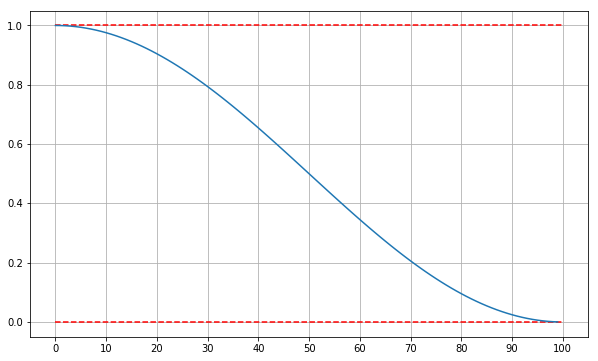

In [16]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
t_max = 100
y = [func(t, 0, 1, t_max) for t in range(t_max)]
ax.plot(y)
ax.set_xticks(list(range(0, t_max+1, 10)))
ax.hlines(0, 0, t_max, 'r', '--')
ax.hlines(1, 0, t_max, 'r', '--')
ax.grid()

As the plot shows, $\eta_{min}$ and $\eta_{max}$ define y-axis limits. The parameter $T_{max}$ defines the period of cosine half-wave. To build a cyclic scheduler, we need to repead this segment several times during training process. Also we could try iteratively increase the period of the segment as the number training epochs increases. The next cell shows how one can do it:

In [17]:
class CosineAnnealingSchedule:
    """
    The schedule class that returns eta multiplier in range from 0.0 to 1.0.
    """
    def __init__(self, eta_min=0.0, eta_max=1.0, t_max=100, t_mult=2):
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.t_max = t_max
        self.t_mult = t_mult
        self.iter = 0

    def update(self, **kwargs):
        self.iter += 1

        eta_min, eta_max, t_max = self.eta_min, self.eta_max, self.t_max

        t = self.iter % t_max
        eta = eta_min + 0.5 * (eta_max - eta_min) * (1 + math.cos(math.pi * t / t_max))
        if t == 0:
            self.iter = 0
            self.t_max *= self.t_mult

        return eta

In [18]:
def plot_schedule(schedule, n=1000):
    points = [schedule.update() for _ in range(n)]
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(points)

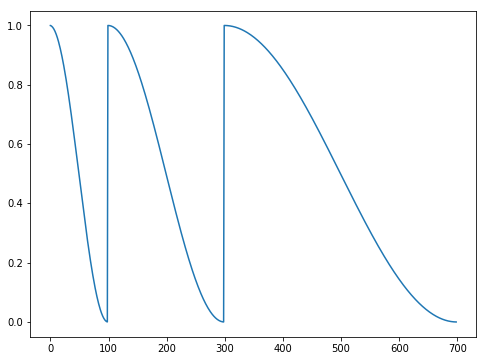

In [19]:
plot_schedule(CosineAnnealingSchedule(), n=699)

The cosine annealing schedule is ready! 

There is an even more interesting scheduler though called [One-Cycle Policy](https://docs.fast.ai/callbacks.one_cycle.html). The idea of this scheduler is to use a single cycle of learning rate increasing-decreasing during the whole traning process. This method was also described by L. N. Smith and is one of the default schedulers in `fastai` library and shows quite good results. To implement this type of scheduler, we just need to combine the previous one with a linear segment at the beginning of training process:

$$
f(t) = \begin{cases} kt + \eta_{min}, & \mbox{if } t < t_0 \\ CosAnneal(t - t_0, \eta_{min}, \eta_{max}) & \mbox{otherwise}\end{cases}
$$

Let's see how it looks in the code:

In [20]:
class OneCycleSchedule:

    def __init__(self, t, linear_pct=0.2, eta_max=1.0, eta_min=None,
                 div_factor=100, decay_to_zero=True):

        if eta_min is None:
            eta_min = eta_max / div_factor

        self.t = t
        self.linear_pct = linear_pct
        self.eta_max = eta_max
        self.eta_min = eta_min

        self.t_cosine = int(math.ceil(t * (1 - linear_pct))) + 1
        self.t_linear = int(math.floor(t * linear_pct))

        self.cosine = CosineAnnealingSchedule(
            eta_min=0 if decay_to_zero else eta_min,
            eta_max=eta_max,
            t_max=self.t_cosine, t_mult=1)
        self.linear = lambda x: x * (eta_max - eta_min) / self.t_linear + eta_min

        self.iter = 0

    def update(self, **kwargs):
        self.iter += 1
        if self.iter <= self.t_linear:
            return self.linear(self.iter)
        else:
            return self.cosine.update()

We use `CosineAnnealingSchedule` class as is, adding conditional logic to include a linear segment at the beggining. We can tune parameters `linear_pct` and `eta`s to adjust scheduler's behavior. Here is a plot:

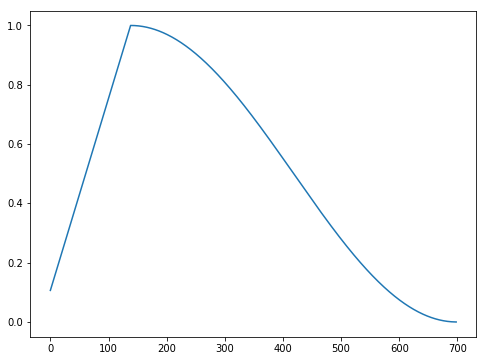

In [21]:
plot_schedule(OneCycleSchedule(699, eta_min=0.1), n=699)

Note that our scheduling functions return values in a normalized range from 0 to 1. They are not intended to be used as learning rates directly but as _multipliers_ reducing/increasing some starting values. Moreover, these functions are not aware about optimizers, neural networks, and `torch`. They are completely decoupled from tensors-related code. 

To make use of these scheduling classes, we need to write an additional class, let's call it `ParameterUpdater`, that will apply a specific schedule to the optimizer parameters:

In [22]:
class ParameterUpdater:

    def __init__(self, schedule, params, opt=None):
        self.schedule = schedule
        self.params = params
        self.opt = opt
        self.start_parameters = None

    def set_optimizer(self, opt):
        self.opt = opt

    def save_start_values(self):
        start = []
        for group in self.opt.param_groups:
            params = {}
            for item in self.params:
                name = item['name']
                if name in group:
                    params[name] = group[name]
            start.append(params)
        self.start_parameters = start

    def current_values(self):
        return [
            {conf['name']: group[conf['name']]
             for conf in self.params}
            for group in self.opt.param_groups]

    def step(self):
        mult = self.schedule.update()
        for i, group in enumerate(self.opt.param_groups):
            for item in self.params:
                name = item['name']
                if name in group:
                    params = self.start_parameters[i]
                    inverse = item.get('inverse', False)
                    start_value = params.get(name)
                    group[name] = start_value * ((1 - mult) if inverse else mult)

The method `save_start_values()` saves the starting values of optimizer parameters to multiply them by scheduling coefficient returned by `update()` method of a schedule classes. The method `step()` performs an actual update of optimizer properties.

Finally, we're ready to wrap our schedules with a callback interface! The implementation is quite straightforward. It delegates most of the functionality to the classes deined above.

In [23]:
class Scheduler(Callback):
    default = [{'name': 'lr'}]

    def __init__(self, schedule, mode='epoch', params_conf=None):
        self.schedule = schedule
        self.params_conf = params_conf or self.default
        self.mode = mode
        self.history = []

    def training_started(self, optimizer, **kwargs):
        self.updater = ParameterUpdater(self.schedule, self.params_conf, optimizer)
        self.updater.save_start_values()

    def batch_ended(self, phase, **kwargs):
        if self.mode == 'batch' and phase.grad:
            self.update_parameters()

    def epoch_ended(self, epoch, **kwargs):
        if self.mode == 'epoch':
            self.update_parameters()

    def update_parameters(self):
        self.updater.step()
        self.history.append(self.updater.current_values())

    def parameter_history(self, name, *names, group_index=0):
        if not self.history:
            return {}
        curve = defaultdict(list)
        names = [name] + list(names)
        for record in self.history:
            group = record[group_index]
            for name in names:
                if name not in group:
                    raise ValueError(f'no history for parameter \'{name}\'')
                curve[name].append(group[name])
        return dict(curve)

## Bells and Whistels

In [24]:
def merge_dicts(ds):
    merged = OrderedDict()
    for d in ds:
        for k, v in d.items():
            merged[k] = v
    return merged

In [25]:
class StreamLogger(Callback):
    """
    Writes performance metrics collected during the training process into list
    of streams.

    Parameters:
        streams: A list of file-like objects with `write()` method.

    """
    def __init__(self, streams=None, log_every=1):
        self.streams = streams or [sys.stdout]
        self.log_every = log_every

    def epoch_ended(self, phases, epoch, **kwargs):
        metrics = merge_dicts([phase.last_metrics for phase in phases])
        values = [f'{k}={v:.4f}' for k, v in metrics.items()]
        values_string = ', '.join(values)
        string = f'Epoch: {epoch:4d} | {values_string}\n'
        for stream in self.streams:
            stream.write(string)
            stream.flush()

In [26]:
class ProgressBar(Callback):

    def training_started(self, phases, **kwargs):
        bars = OrderedDict()
        for phase in phases:
            bars[phase.name] = tqdm(total=len(phase.loader), desc=phase.name)
        self.bars = bars

    def batch_ended(self, phase, **kwargs):
        bar = self.bars[phase.name]
        bar.set_postfix_str(f'loss: {phase.last_loss:.4f}')
        bar.update(1)
        bar.refresh()

    def epoch_ended(self, **kwargs):
        for bar in self.bars.values():
            bar.n = 0
            bar.refresh()

    def training_ended(self, **kwargs):
        for bar in self.bars.values():
            bar.n = bar.total
            bar.refresh()
            bar.close()

## Training Phase

There is a one more thing to implement before we can run our trianing loop. It is not really a part of our callbacks hierachy but helps to make our loop more consice and consistent. The idea is to keep training and validation metrics in separate objects, and pass these objects into callbacks. Therefore, we don't need any additional explicit loops or flags to deal with validation. Everything is encapsulated within `Phase` class. The field `Phase.grad` determines if we need to compute gradients or not, i.e., if we're are in a training or validation mode.

In [27]:
class Phase:
    """
    Model training loop phase.

    Each model's training loop iteration could be separated into (at least) two
    phases: training and validation. The instances of this class track
    metrics and counters, related to the specific phase, and keep the reference
    to subset of data, used during phase.
    """

    def __init__(self, name, loader, grad=True):
        self.name = name
        self.loader = loader
        self.grad = grad
        self.batch_loss = None
        self.batch_index = 0
        self.rolling_loss = 0
        self.losses = []
        self.metrics = OrderedDict()

    @property
    def last_loss(self):
        return self.losses[-1] if self.losses else None

    @property
    def last_metrics(self):
        metrics = OrderedDict()
        metrics[f'{self.name}_loss'] = self.last_loss
        for name, values in self.metrics.items():
            metrics[f'{self.name}_{name}'] = values[-1]
        return metrics

    @property
    def metrics_history(self):
        metrics = OrderedDict()
        for name, values in self.metrics.items():
            metrics[f'{self.name}_{name}'] = values
        return metrics

    def update(self, loss):
        self.losses.append(loss)

    def update_metric(self, name, value):
        if name not in self.metrics:
            self.metrics[name] = []
        self.metrics[name].append(value)

## Assemble Things Together

Now we have everything we need to test our trainign loop. Let's define a simple convnet and apply it to MNIST dataset using `torch` and `torchvision` classes.

In [28]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [29]:
def make_phases(train, valid, bs=128, n_jobs=0):
    return [
        Phase('train', DataLoader(train, bs, shuffle=True, num_workers=n_jobs)),
        Phase('valid', DataLoader(valid, bs, num_workers=n_jobs), grad=False)
    ]

In [30]:
data_path = Path.home()/'data'/'mnist'

mnist_stats = ((0.15,), (0.15,))

epochs = 3

train_ds = MNIST(
    data_path, 
    train=True, 
    download=True,
    transform=T.Compose([
        T.RandomAffine(5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        T.ToTensor(),
        T.Normalize(*mnist_stats)
    ])
)

valid_ds = MNIST(
    data_path, 
    train=False, 
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(*mnist_stats)
    ])
)

phases = make_phases(train_ds, valid_ds, bs=1024, n_jobs=4)
model = Net()
opt = optim.Adam(model.parameters(), lr=1e-2)
cb = CallbacksGroup([
    RollingLoss(),
    Accuracy(),
    Scheduler(
        OneCycleSchedule(t=len(phases[0].loader) * epochs),
        mode='batch'
    ),
    StreamLogger(),
    ProgressBar()
])

In [31]:
train(model, opt, phases, cb, epochs=epochs, loss_fn=F.cross_entropy)

Epoch:    1 | train_loss=0.8907, train_accuracy=0.6387, valid_loss=0.1027, valid_accuracy=0.9695
Epoch:    2 | train_loss=0.4990, train_accuracy=0.8822, valid_loss=0.0828, valid_accuracy=0.9794
Epoch:    3 | train_loss=0.3639, train_accuracy=0.9086, valid_loss=0.0723, valid_accuracy=0.9823




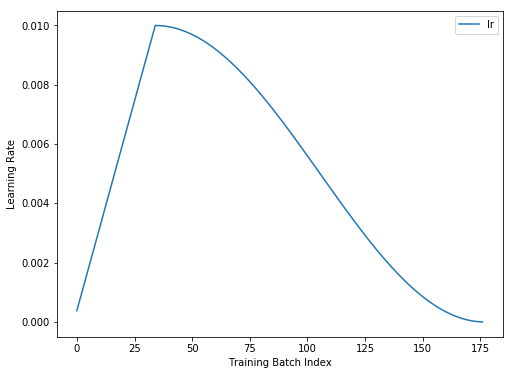

In [32]:
lr_history = pd.DataFrame(cb['scheduler'].parameter_history('lr'))
ax = lr_history.plot(figsize=(8, 6))
ax.set_xlabel('Training Batch Index')
ax.set_ylabel('Learning Rate');

## A More Complex Model

In [33]:
def as_sequential(model: nn.Module):
    """Converts model with nested submodules into Sequential model."""

    return nn.Sequential(*list(model.children()))

In [34]:
class AdaptiveConcatPool2d(nn.Module):
    """Applies average and maximal adaptive pooling to the tensor and
    concatenates results into a single tensor.

    The idea is taken from fastai library.
    """
    def __init__(self, size=1):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(size)
        self.max = nn.AdaptiveMaxPool2d(size)

    def forward(self, x):
        return torch.cat([self.max(x), self.avg(x)], 1)

In [ ]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def forward(self, x):
        return x.view(x.size(0), -1)

In [ ]:
class ResNetClassifier(nn.Module):

    def __init__(self, n_classes, arch=models.resnet18):
        super().__init__()

        model = arch(True)
        seq_model = as_sequential(model)
        backbone, classifier = seq_model[:-2], seq_model[-2:]

        self.backbone = backbone
        self.top = nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            
            nn.Linear(1024, 512),
            nn.Dropout(0.25),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, n_classes)
        )
    
    def forward(self, x):
        return self.top(self.backbone(x))

In [ ]:
def classifier_weights(m: nn.Module, bn=(1, 1e-3)):
    """Initializes layers weights for a classification model."""
    
    name = classname(m)

    with torch.no_grad():
        if name.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)

        elif name.find('BatchNorm') != -1:
            weight, bias = bn
            nn.init.constant_(m.weight, weight)
            nn.init.constant_(m.bias, bias)

        elif name == 'Linear':
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [ ]:
def freeze(m, freeze=True, bn=False):
    for child in m.children():
        name = classname(child)
        if not bn and name.find('BatchNorm') != -1:
            continue
        for p in child.parameters():
            p.requires_grad = not freeze

In [ ]:
data_path = Path.home()/'data'/'cifar10'

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

epochs = 10

train_ds = CIFAR10(
    data_path, 
    train=True, 
    download=True,
    transform=T.Compose([
        T.Resize(224),
        T.RandomAffine(5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        T.ColorJitter(brightness=0.3, saturation=0.5),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(*imagenet_stats)
    ])
)

valid_ds = CIFAR10(
    data_path, 
    train=False, 
    transform=T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(*imagenet_stats)
    ])
)

phases = make_phases(train_ds, valid_ds, bs=200, n_jobs=8)

model = ResNetClassifier(10)
model.top.apply(classifier_weights)
freeze(model.backbone)

opt = optim.Adam(model.parameters(), lr=1e-2)

cb = CallbacksGroup([
    RollingLoss(),
    Accuracy(),
    Scheduler(
        OneCycleSchedule(t=len(phases[0].loader) * epochs),
        mode='batch'
    ),
    StreamLogger(),
    ProgressBar()
])

Files already downloaded and verified


In [ ]:
train(model, opt, phases, cb, epochs=epochs, loss_fn=F.cross_entropy)

Epoch:    1 | train_loss=0.9568, train_accuracy=0.5776, valid_loss=0.6756, valid_accuracy=0.7637
Epoch:    2 | train_loss=0.8399, train_accuracy=0.7087, valid_loss=0.6623, valid_accuracy=0.7671
